In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os
import json

Our metric of an actor's success can be based on two factors: 
 - awards (we consider 3 prestigiuos awards: Oscar, Golden Globe and Critics Choice) show an actor's recognition by the professional community
 - popularity shows an actor's recognition by the broad audience

 We use two sources of popularity estimation: a tmdB popularity of an actor and YouGov database of the most famous actors

We can aggregate these factors as follows:

$ Success(P, W) = P + F + \sqrt{W} $

In the formula P and F corresponds to tmdB popularity and YouGov Fame, W is number of times the actor became an award winner or, in case of Oscar, nominant. All terms are normalized, in case of awards we're also taking the square root emphasizing the difference between 0 awards and at least 1 award.

In [4]:
# database with Oscar awards retrieved from https://en.wikipedia.org/wiki/List_of_actors_with_Academy_Award_nominations
oscars_df = pd.read_csv('../Data/preprocessed_data/oscars_db.csv')
# database with Golden Globe awards
gg_awards_df = pd.read_csv('../Data/preprocessed_data/gg_awards.csv')
# database with Critic Choise awards
cc_awards_df = pd.read_csv('../Data/preprocessed_data/cc_awards.csv')

In [5]:
gg_awards_df = gg_awards_df.rename(columns={"Actor": "name"})
cc_awards_df = cc_awards_df.rename(columns={"Actor": "name"})

In [6]:
# give more weight to the Oscar wins compared to nominations
oscars_df["wins"] = oscars_df["wins"].apply(lambda x: 2*x)
# some competitive categories of an award are considered more important, so we give them more weight
for col_name in ["GG_Best_Actor_Drama", "GG_Best_Actress_Drama",
                 "GG_Best_Actor_Comedy_or_Musical", "GG_Best_Actress_Comedy_or_Musical"]:
    gg_awards_df[col_name] = gg_awards_df[col_name].apply(lambda x: 2*x)
for col_name in ["Best_Actor", "Best_Actress"]:
    cc_awards_df[col_name] = cc_awards_df[col_name].apply(lambda x: 2*x)

In [7]:
oscars_df["oscar_total"] = oscars_df[["nominations", "wins"]].sum(axis=1)
oscars_df = oscars_df[["name", "oscar_total"]]
gg_awards_df["gg_total"] = gg_awards_df[["GG_Best_Actor_Drama", "GG_Best_Actress_Drama", 
                                         "GG_Best_Supporting_Actor", "GG_Best_Supporting_Actress", 
                                         "GG_Best_Actor_Comedy_or_Musical",
                                         "GG_Best_Actress_Comedy_or_Musical"]].sum(axis=1)
gg_awards_df = gg_awards_df[["name", "gg_total"]]
cc_awards_df["cc_total"] = cc_awards_df[["Best_Actor", "Best_Actress", "Best_Supporting_Actor",
                                         "Best_Supporting_Actress"]].sum(axis=1)
cc_awards_df = cc_awards_df[["name", "cc_total"]]

In [8]:
gg_awards_sum_df = gg_awards_df.groupby(by="name").sum()
cc_awards_sum_df = cc_awards_df.groupby(by="name").sum()

In [9]:
filtered_actors = pd.read_csv("../Data/preprocessed_data/tmdb_acting_in_2003_and_later.csv")

In [10]:
awards_df = pd.merge(left=oscars_df, right=gg_awards_sum_df, how='outer', on="name")
awards_df = pd.merge(left=awards_df, right=cc_awards_sum_df, how='outer', on="name")
awards_df = awards_df.fillna(0.0)
awards_df['awards_total'] = awards_df[['oscar_total', 'gg_total', 'cc_total']].sum(axis=1)
# awards_df = awards_df[["name", "awards_total"]]
display(awards_df)

,name,oscar_total,gg_total,cc_total,awards_total
0,Barkhad Abdi,1.0,1.0,1.0,3.0
1,F. Murray Abraham,3.0,2.0,0.0,5.0
2,Amy Adams,6.0,12.0,7.0,25.0
3,Nick Adams,1.0,0.0,0.0,1.0
4,Isabelle Adjani,2.0,0.0,0.0,2.0
...,...,...,...,...,...
1352,Sidney Flanigan,0.0,0.0,2.0,2.0
1353,Sterling K. Brown,0.0,0.0,1.0,1.0
1354,Tiffany Haddish,0.0,0.0,1.0,1.0
1355,Zendaya,0.0,0.0,2.0,2.0


In [11]:
filtered_actors_with_awards = pd.merge(left=filtered_actors["name"], right=awards_df, 
                                       how="outer", on="name")

In [12]:
filtered_actors_with_awards = filtered_actors_with_awards.fillna(0.0)
display(filtered_actors_with_awards)

,name,oscar_total,gg_total,cc_total,awards_total
0,Gary Oldman,5.0,4.0,4.0,13.0
1,Florence Pugh,1.0,0.0,1.0,2.0
2,Jason Statham,0.0,0.0,0.0,0.0
3,Jackie Chan,0.0,0.0,0.0,0.0
4,Scarlett Johansson,2.0,9.0,5.0,16.0
...,...,...,...,...,...
8704,Meryl Streep (TIE),0.0,0.0,4.0,4.0
8705,Michelle Williams (TIE),0.0,0.0,1.0,1.0
8706,Sandra Bullock (TIE),0.0,0.0,2.0,2.0
8707,Sidney Flanigan,0.0,0.0,2.0,2.0


In [13]:
filtered_actors_with_awards.to_csv("filtered_actors_with_awards.csv", index=False)

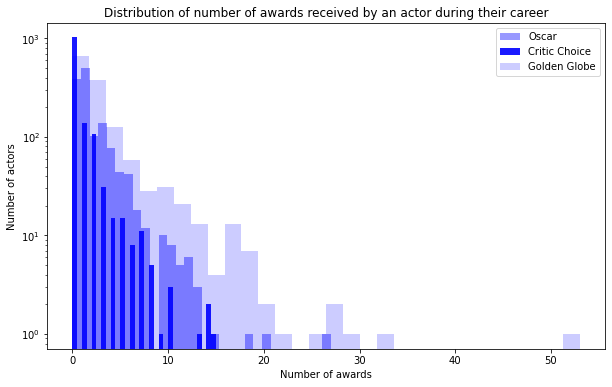

In [15]:
plt.figure(figsize=(10, 6))

plt.hist(awards_df['oscar_total'], bins=30, color='b', alpha=0.4, label='Oscar')
plt.hist(awards_df['cc_total'], bins=30, color='b', alpha=0.9, label='Critic Choice')
plt.hist(awards_df['gg_total'], bins=30, color='b', alpha=0.2, label='Golden Globe')

plt.xlabel('Number of awards')
plt.yscale('log')
plt.ylabel('Number of actors')
plt.title('Distribution of number of awards received by an actor during their career')
plt.legend()

Popularity of the actors and films they are known for were extracted in Preprocessing/actors_preprocessing.ipynb. In our analysis we are targeting Hollywood actors, since the Oscar is Hollywood-biased. For this, we apply filtering based on the prevalent language of the most popular films ("original_language" field in the database) of each actor and leave only English ones. 

*This filtering does not reject British film industry but their movies and actors are also eligible for Oscar.

In [123]:
actors_df = pd.read_csv('../Data/preprocessed_data/actors_db.csv')
actors_df = actors_df[actors_df["original_language"] == "en"] # English movies filtering
popularity_df = actors_df[["name", "popularity", "known_for"]] # for each actor known_for contains top-3 most recognised movies
popularity_df["known_for"] = popularity_df["known_for"].apply(lambda x: ast.literal_eval(x))
display(popularity_df)
print(f"There are {popularity_df.shape[0]} actors in the filtered dataset")

c:\Users\1\Anaconda\envs\hello-world\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,name,popularity,known_for
1,Gary Oldman,220.449,"[{'adult': False, 'backdrop_path': '/nMKdUUepR..."
3,Florence Pugh,176.589,"[{'adult': False, 'backdrop_path': '/aAM3cQmYG..."
4,Jason Statham,162.466,"[{'adult': False, 'backdrop_path': '/ysKahAEPP..."
6,Jackie Chan,156.714,"[{'adult': False, 'backdrop_path': '/r4yFYBEcV..."
7,Scarlett Johansson,156.460,"[{'adult': False, 'backdrop_path': '/ozVwXlfxq..."
...,...,...,...
9574,Richard Derr,14.134,"[{'adult': False, 'backdrop_path': '/ws8eX1paK..."
9575,Michael Maloney,14.134,"[{'adult': False, 'backdrop_path': '/9YoLdWeBS..."
9576,Gaia Scodellaro,14.133,"[{'adult': False, 'backdrop_path': '/tC78Pck2Y..."
9578,Peter Cullen,14.133,"[{'adult': False, 'backdrop_path': '/2vFuG6bWG..."


There are 8441 actors in the filtered dataset


To mitigate the effect of trend, the actor popularity metric was normalized using a “within group” z-score normailzation. Each actor improved popularity score is relative to the mean and standard deviation of the scores of actors whose most recent movie was released in the same year range.

In [124]:
def get_last_release_date(row):
    actor_movies = row["known_for"]
    sorted_release_dates = sorted([x["release_date"] for x in actor_movies if "release_date" in x])
    if len(sorted_release_dates):
        return sorted_release_dates[-1]
    return "None"
    
# extract year of the last release    
popularity_df["last_release_date"] = popularity_df.apply(get_last_release_date, axis=1)
popularity_df["last_release_year"] = popularity_df["last_release_date"].apply(lambda x: x.split("-")[0])

c:\Users\1\Anaconda\envs\hello-world\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
c:\Users\1\Anaconda\envs\hello-world\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [125]:
# find mean and std of popularity for actors with equal last release years
df_mean = popularity_df.groupby("last_release_year")["popularity"].mean()
df_std = popularity_df.groupby("last_release_year")["popularity"].std()

In [126]:
# time-aware normalization
def time_scaling(row):
    mean = df_mean[row["last_release_year"]]
    std = df_std[row["last_release_year"]]
    if std != 0.0:
        return (row["popularity"] - mean) / std
    return row["popularity"]

popularity_df["popularity_scaled"] = popularity_df.apply(time_scaling, axis=1)

c:\Users\1\Anaconda\envs\hello-world\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [127]:
# make shift to make all popularity values positive
popularity_df["popularity_scaled"] = popularity_df["popularity_scaled"] - popularity_df["popularity_scaled"].min()
popularity_df["last_release_date"] = pd.to_datetime(popularity_df["last_release_date"], errors='coerce', yearfirst=True)

c:\Users\1\Anaconda\envs\hello-world\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\1\Anaconda\envs\hello-world\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


We then compare distributions before and after this time-aware normalization

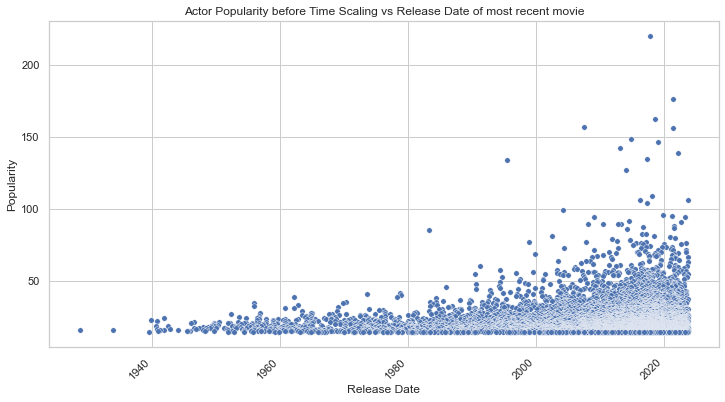

In [121]:
sns.set(style="whitegrid")

# Create a scatter plot
plt.figure(figsize=(12, 6))
scatter_plot = sns.scatterplot(x="last_release_date", y="popularity", 
                               data=popularity_df, 
                               s=30, palette='colorblind')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set plot title and labels
plt.title('Actor Popularity before Time Scaling vs Release Date of most recent movie')
plt.xlabel('Release Date')
plt.ylabel('Popularity')

# Show the plot
plt.show()

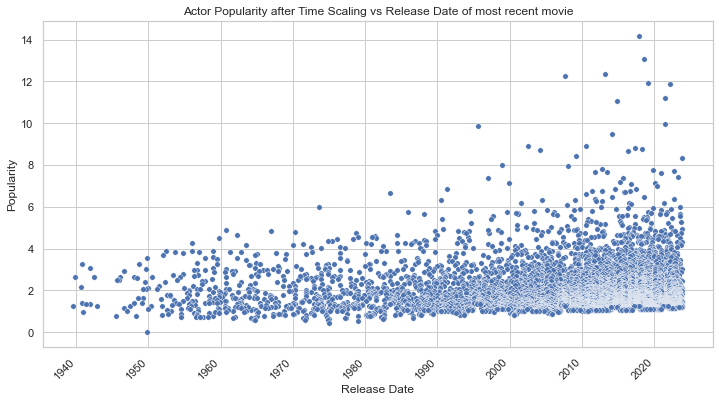

In [122]:
sns.set(style="whitegrid")

# Create a scatter plot
plt.figure(figsize=(12, 6))
scatter_plot = sns.scatterplot(x="last_release_date", y="popularity_scaled", 
                               data=popularity_df, 
                               s=30, palette='colorblind')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set plot title and labels
plt.title('Actor Popularity after Time Scaling vs Release Date of most recent movie')
plt.xlabel('Release Date')
plt.ylabel('Popularity')

# Show the plot
plt.show()

We can see that normalization helps to decrease a trend effect of higher popularity for recently performed actors

In [128]:
success_df = pd.merge(left=popularity_df[["name", "popularity_scaled"]], 
                      right=filtered_actors_with_awards[["name", "awards_total"]], 
                      how="left", on="name")
success_df = success_df.fillna(0)

Finally we add the estimation of fame from YouGov database

In [131]:
fame_df = pd.read_csv('../Data/preprocessed_data/actors_final.csv')

In [132]:
success_df = pd.merge(left=fame_df[["name", "Popularity (%)"]],
                      right=success_df, how="inner", on="name")

In [137]:
success_df = success_df.rename(columns={"Popularity (%)": "fame", "popularity_scaled": "popularity"})

In [138]:
# min-max scaling for the popularity and award
success_df["fame"] = (success_df["fame"] - success_df["fame"].min()) / (success_df["fame"].max() - success_df["fame"].min())
success_df["popularity"] = (success_df["popularity"] - success_df["popularity"].min()) / (success_df["popularity"].max() - success_df["popularity"].min())
success_df["awards_total"] = (success_df["awards_total"] - success_df["awards_total"].min()) / (success_df["awards_total"].max() - success_df["awards_total"].min())

# taking square root of awards emphasizing the difference between 0 awards and at least 1 award
success_df["awards_total"] = success_df["awards_total"].apply(lambda x: x ** 0.5)

display(success_df)

,name,fame,popularity,awards_total
0,Jennifer Lawrence,0.936695,0.289771,0.516398
1,Channing Tatum,0.915593,0.359567,0.000000
2,Larry the Cable Guy,0.905042,0.143066,0.000000
3,Jaden Smith,0.894491,0.118156,0.000000
4,Zac Efron,0.862839,0.152550,0.000000
...,...,...,...,...
6709,Demián Bichir,0.388050,0.054332,0.105409
6710,Tobin Bell,0.388050,0.141845,0.000000
6711,Mercedes McCambridge,0.377499,0.033130,0.235702
6712,Jacki Weaver,0.366948,0.123106,0.210819


In [139]:
# finally aggregate popularity and awards: Success(P, W) = P + F + \sqrt{W} 
success_df["success"] = success_df[["fame", "popularity", "awards_total"]].sum(axis=1)

In [140]:
success_df = success_df[["name", "success"]]
success_df.to_csv("../Data/preprocessed_data/success_db.csv", index=False)

Text(0.5, 1.0, 'Distribution of actors success')

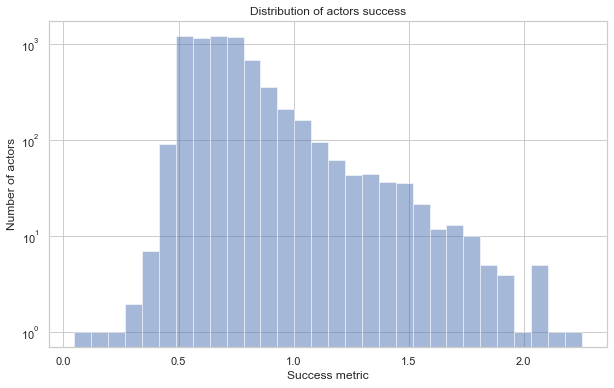

In [144]:
plt.figure(figsize=(10, 6))

plt.hist(success_df['success'], bins=30, color='b', alpha=0.5)

plt.xlabel('Success metric')
plt.yscale('log')
plt.ylabel('Number of actors')
plt.title('Distribution of actors success')